In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('cleaned_lumoshive_data.csv')

/var/folders/dw/l4h116bs0p1614knym74hj4m0000gn/T/ipykernel_60274/2200081736.py:1: DtypeWarning: Columns (4,6,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_lumoshive_data.csv')


In [3]:
df.head()

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,...,service_price,currency,profile_status,publisher,trxid,pixel,handset,browser,attempt_charging,success_billing
0,302164,2023-09-13 09:47:57,thailand,ais,459505104,sms,66988602911,not found,daily,not found,...,6.0,bath,active,not found,2.02309130707494e+19,not found,not found,not found,15,0
1,3521,2023-09-13 09:21:13,thailand,ais,459505104,sms,66822243080,not found,daily,not found,...,6.0,bath,active,not found,2.02309130707243e+19,not found,not found,not found,15,0
2,1,2023-09-13 09:20:20,thailand,ais,459505106,ivr,666131,not found,not found,not found,...,6.0,bath,active,not found,2.02308251402057e+19,not found,not found,not found,1,1
3,4999335,2023-09-13 14:00:22,thailand,ais,459505105,wap,66650020857,not found,daily,star,...,6.0,bath,active,star,2.02309130710521e+19,star,not found,not found,5,0
4,273196,2023-09-13 09:45:33,thailand,ais,459505104,sms,66635959286,not found,daily,not found,...,6.0,bath,active,not found,2.02309130701156e+19,not found,not found,not found,15,0


In [4]:
# Mapping dictionary for currency conversion
currency_mapping = {'bath': 441.23, 'cfa franc': 25.21040, 'lak': 0.75, 'kip': 0.75, 'rial': 4143.17, 'idr': 1, 'baisa': 4143.17, 'php': 279.48, 'baht':  449.06}

# Conversion function
def convert_to_rupiah(value, currency):
    conversion_rate = currency_mapping.get(currency, 1)
    return value * conversion_rate

# Apply the conversion to 'service_price' column and create a new column 'converted_service_price'
df['converted_service_price'] = df.apply(lambda row: convert_to_rupiah(row['service_price'], row['currency']), axis=1)

# Apply the conversion to 'revenue' column and create a new column 'converted_revenue'
df['converted_revenue'] = df.apply(lambda row: convert_to_rupiah(row['revenue'], row['currency']), axis=1)

# Display the updated DataFrame with new columns
print(df)
# Display the specific rows with the new columns
print(df[['service_price', 'currency', 'converted_service_price', 'revenue', 'converted_revenue']].head())

              id           created_at   country   operator    service source  \
0         302164  2023-09-13 09:47:57  thailand        ais  459505104    sms   
1           3521  2023-09-13 09:21:13  thailand        ais  459505104    sms   
2              1  2023-09-13 09:20:20  thailand        ais  459505106    ivr   
3        4999335  2023-09-13 14:00:22  thailand        ais  459505105    wap   
4         273196  2023-09-13 09:45:33  thailand        ais  459505104    sms   
...          ...                  ...       ...        ...        ...    ...   
365609     97584            not found  thailand        ais  459509903    sms   
365610    384166            not found  thailand        ais  459505105    wap   
365611  27966473            not found  thailand  aisgemezz         ge    sms   
365612    187009            not found  thailand        ais  459509903    sms   
365613  27906860            not found  thailand  aisgemezz         ge    sms   

             msisdn     status      cyc

In [5]:
# # Sort data by ID and Service Price
# df.sort_values(by=['id', 'subs_date'], inplace=True)

# # Create a new column to identify if the service is new compared to the previous record
# df['previous_service'] = df.groupby('id')['service'].shift(1)  # Shift the service by one row within each user ID
# df['cross_sell_success'] = ((df['service'] != df['previous_service']) & 
#                             (df['service'] != "not found") & 
#                             (df['service'] != -1)).astype(int)

In [6]:
# Sort data by ID and Service Price
df.sort_values(by=['id', 'subs_date'], inplace=True)

# Create the label by grouping transactions by user ID and identify cross-sell events based on different service
df['cross_sell'] = (df['service_price'].lt(df.groupby('id')['service_price'].shift())) | \
                    df['service'].ne(df.groupby('id')['service'].shift()) & \
                    (df['profile_status'] == 'active')
                    
# Fill NaN values in the first row after sorting
df['cross_sell'].fillna(False, inplace=True)

In [7]:
df['cross_sell'].value_counts()

cross_sell
True     308288
False     57326
Name: count, dtype: int64

In [8]:
# Multiple categorical columns to be encoded
columns_to_encode = ['service', 'source', 'status', 'operator', 'country', 'profile_status', 'adnet', 'cycle', 'currency']

# Created a copy of the DataFrame to avoid modifying the original data
encoded_data = df.copy()

encoded_data[columns_to_encode] = np.where(encoded_data[columns_to_encode] == 'not found', -1, encoded_data[columns_to_encode])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each column in the list 'columns_to_encode'
for col in columns_to_encode:
    encoded_data[col] = label_encoder.fit_transform(df[col].astype(str))

In [9]:
encoded_data['browser'] = np.where((encoded_data['browser'] == 'not found') | (encoded_data['browser'] == 'No Detected'), -1, encoded_data['browser'])
label_encoder = LabelEncoder()
encoded_data['browser'] = label_encoder.fit_transform(df['browser'])

In [10]:
# Convert 'subs_date' column to datetime format if it's not already in datetime64 format
encoded_data['subs_date'] = pd.to_datetime(encoded_data['subs_date'])

# Extract year, month, and day as separate numerical features
encoded_data['subs_year'] = encoded_data['subs_date'].dt.year
encoded_data['subs_month'] = encoded_data['subs_date'].dt.month
encoded_data['subs_day'] = encoded_data['subs_date'].dt.day
encoded_data['subs_hour'] = encoded_data['subs_date'].dt.hour
encoded_data['subs_minute'] = encoded_data['subs_date'].dt.minute
encoded_data['subs_second'] = encoded_data['subs_date'].dt.second

In [11]:
encoded_data['freemium_end_date'] = pd.to_datetime(encoded_data['freemium_end_date'])  # Convert to datetime format

encoded_data['freemium_end_year'] = encoded_data['freemium_end_date'].dt.year
encoded_data['freemium_end_month'] = encoded_data['freemium_end_date'].dt.month
encoded_data['freemium_end_day'] = encoded_data['freemium_end_date'].dt.day
encoded_data['freemium_end_hour'] = encoded_data['freemium_end_date'].dt.hour
encoded_data['freemium_end_minute'] = encoded_data['freemium_end_date'].dt.minute
encoded_data['freemium_end_second'] = encoded_data['freemium_end_date'].dt.second

In [12]:
encoded_data['renewal_date'] = pd.to_datetime(encoded_data['renewal_date'], format='mixed')

# Extract year, month, and day as separate numerical features
encoded_data['renewal_year'] = encoded_data['renewal_date'].dt.year
encoded_data['renewal_month'] = encoded_data['renewal_date'].dt.month
encoded_data['renewal_day'] = encoded_data['renewal_date'].dt.day
encoded_data['renewal_hour'] = encoded_data['renewal_date'].dt.hour
encoded_data['renewal_minute'] = encoded_data['renewal_date'].dt.minute
encoded_data['renewal_second'] = encoded_data['renewal_date'].dt.second

In [13]:
encoded_data['unsubs_date'] = pd.to_datetime(encoded_data['unsubs_date'], utc=True, errors='coerce')
encoded_data['unsubs_date'] = encoded_data['unsubs_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [14]:
# Create a condition for 'subscription_duration' based on 'unsubs_date' being not null
condition = encoded_data['unsubs_date'].notnull()
encoded_data['unsubs_date'] = pd.to_datetime(encoded_data['unsubs_date'])
encoded_data['subs_date'] = pd.to_datetime(encoded_data['subs_date'])
encoded_data['created_at'] = pd.to_datetime(encoded_data['created_at'], errors='coerce')

# Apply the condition using numpy.where
encoded_data['subscription_duration'] = np.where(
    condition,
    (encoded_data['unsubs_date'] - encoded_data['subs_date']).dt.days,
    (encoded_data['created_at'] - encoded_data['subs_date']).dt.days
)

encoded_data['subscription_duration'] = encoded_data['subscription_duration'].fillna(-1)

In [15]:
# Select features and target label

features = ['service', 'cycle', 'currency', 'attempt_charging', 'country',
        'renewal_year', 'renewal_month', 'renewal_day',
        'converted_revenue', 'subscription_duration', 'browser']
target = 'cross_sell'

# Split data into features (X) and target label (y)
X = encoded_data[features]
y = encoded_data[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
def plot_confusion_matrix_and_roc_curves(model, X_test, y_test, y_pred):

    fig, axes = plt.subplots(1,2, figsize=(22,5))

    cm = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, ax = axes[0], annot=labels, fmt='',cmap='Blues')
    axes[0].set_title('Confusion Matrix', fontdict={'fontsize': 16, 'fontweight':'bold'})

    # predict probabilities
    pred_proba = model.predict_proba(X_test)

    # roc curve for models
    fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1], pos_label=1)
       
    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

    plt.subplot(1, 2, 2)
    # plot roc curves
    plt.plot(fpr, tpr,linestyle='--',color='red', label = type(model).__name__)

    plt.plot(p_fpr, p_tpr, linestyle='-', color='blue')
    # title
    plt.title('ROC curve', fontdict={'fontsize': 16, 'fontweight':'bold'})
    # x label
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    # y label
    plt.ylabel('True Positive rate', fontdict={'fontsize': 12})

    plt.legend(loc='best')
    plt.show()

def evaluation_metrics(name, independent_feature_length, y_pred, y_test):

    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = [accuracy_score(y_test,y_pred)]  #Accuracy Score
    metrics_dict['Precision'] = [precision_score(y_test,y_pred)] #Precision
    metrics_dict['Recall'] = [recall_score(y_test,y_pred)] #Recall
    metrics_dict['F1_Score'] = [f1_score(y_test,y_pred)] #F1 Score
    metrics_dict['ROC_AUC_Score'] = [roc_auc_score(y_test, y_pred)] #ROC AUC Score
    metrics_dict['Log_Loss'] = [log_loss(y_test, y_pred)] #Log Loss

    metrics_df = pd.DataFrame(metrics_dict)

    print(metrics_df)

def perform_ml_algorithm(x_train, x_test, y_train, y_test, model):
    print('-----'*10+f'\n{type(model).__name__}\n'+'-----'*10)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print(f'\nEvaluation of {type(model).__name__} :\n'+'-----'*10)
    evaluation_metrics(type(model).__name__, len(list(x_train.columns)), y_pred, y_test)

    print()
    plot_confusion_matrix_and_roc_curves(model, x_test, y_test, y_pred)

def ml_algorithm_implementation(df, model):

    # Select features and target label
    features = ['service', 'cycle', 'currency', 'attempt_charging', 
        'renewal_year', 'renewal_month', 'renewal_day',
        'converted_revenue', 'subscription_duration', 'browser']
    target = 'cross_sell'

    # Split data into features (X) and target label (y)
    X = encoded_data[features]
    y = encoded_data[target]
    

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    perform_ml_algorithm(X_train, X_test, y_train, y_test, model)

In [17]:
import shap 

def calculate_shap_values(model, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    return shap_values

def plot_shap_summary(shap_values):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values)

def plot_shap_feature_importance(shap_values):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, plot_type='bar')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


--------------------------------------------------
XGBClassifier
--------------------------------------------------

Evaluation of XGBClassifier :
--------------------------------------------------
   Accuracy_Score  Precision   Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.972457   0.990247  0.97689  0.983523       0.962908  0.992737



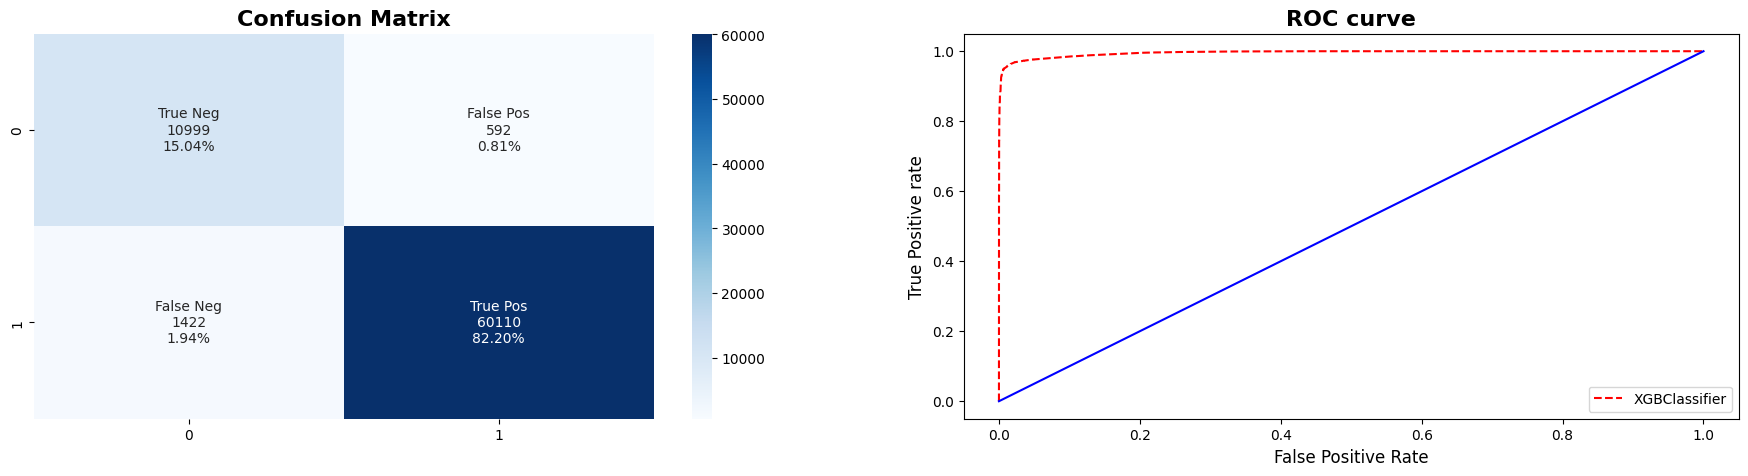

In [18]:
ml_algorithm_implementation(encoded_data, XGBClassifier())

[23:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


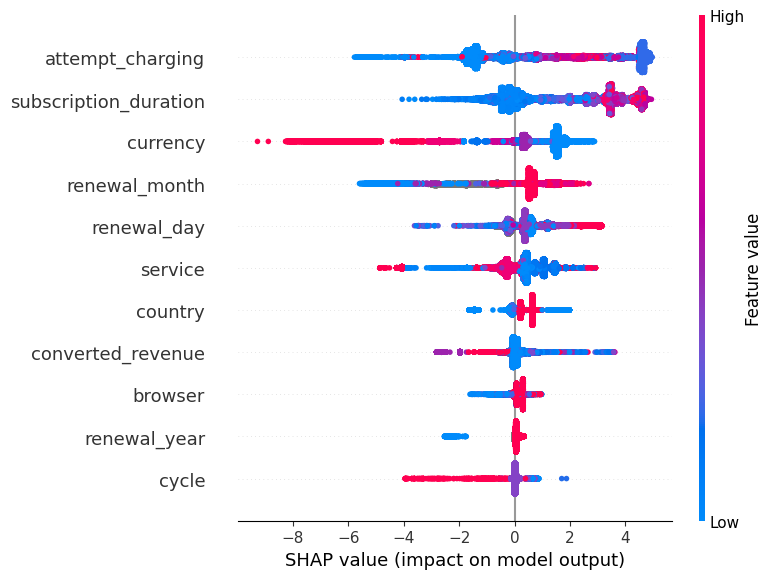

In [19]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features, class_names=target)

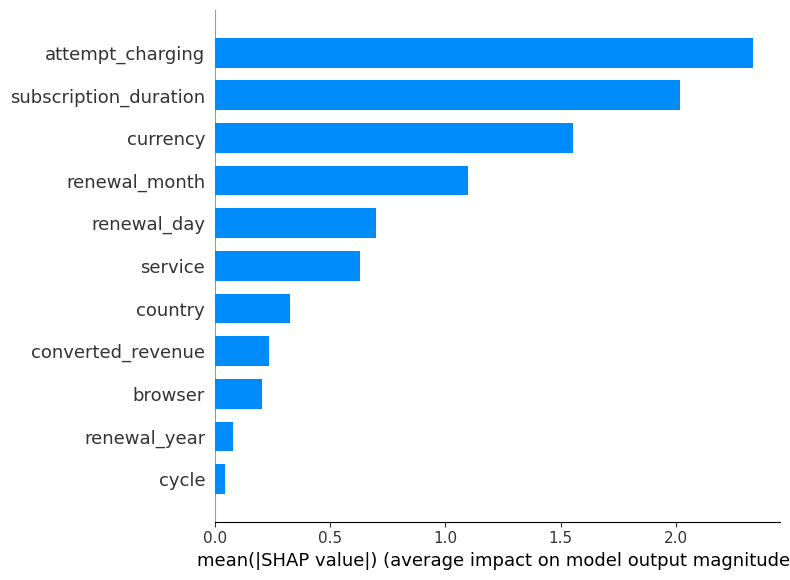

In [20]:
shap.summary_plot(shap_values, X_test, feature_names=features, class_names=target, plot_type="bar")

--------------------------------------------------
HistGradientBoostingClassifier
--------------------------------------------------

Evaluation of HistGradientBoostingClassifier :
--------------------------------------------------
   Accuracy_Score  Precision    Recall  F1_Score  ROC_AUC_Score  Log_Loss
0        0.964772   0.997016  0.961012  0.978683       0.972871  1.269757



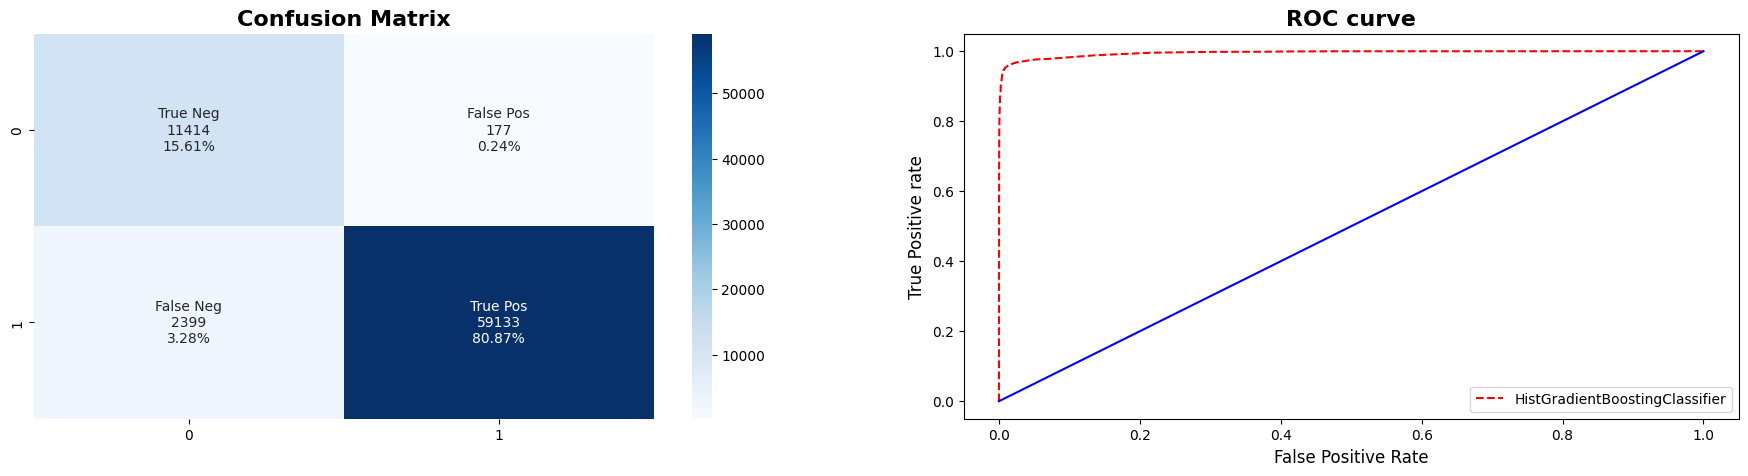

In [21]:
ml_algorithm_implementation(encoded_data, HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight='balanced'))

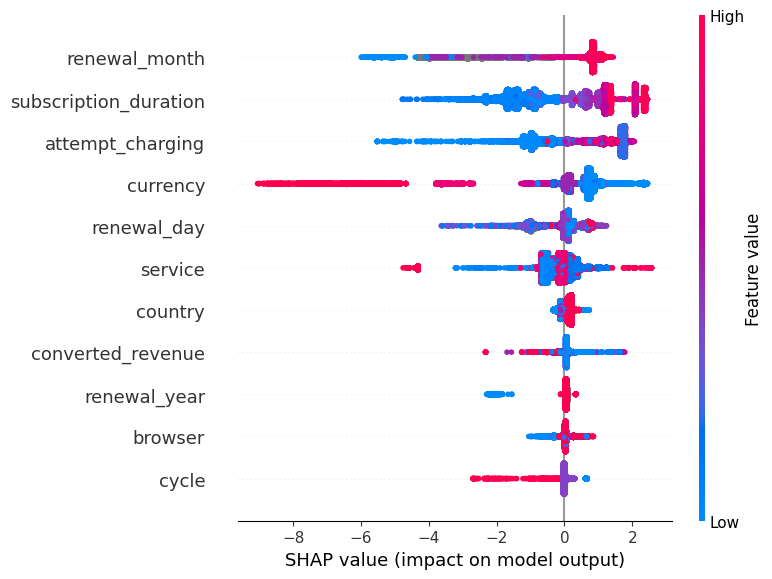

In [22]:
model_hist_boost = HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight='balanced')
model_hist_boost.fit(X_train, y_train)

explainer = shap.TreeExplainer(model_hist_boost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features, class_names=target)

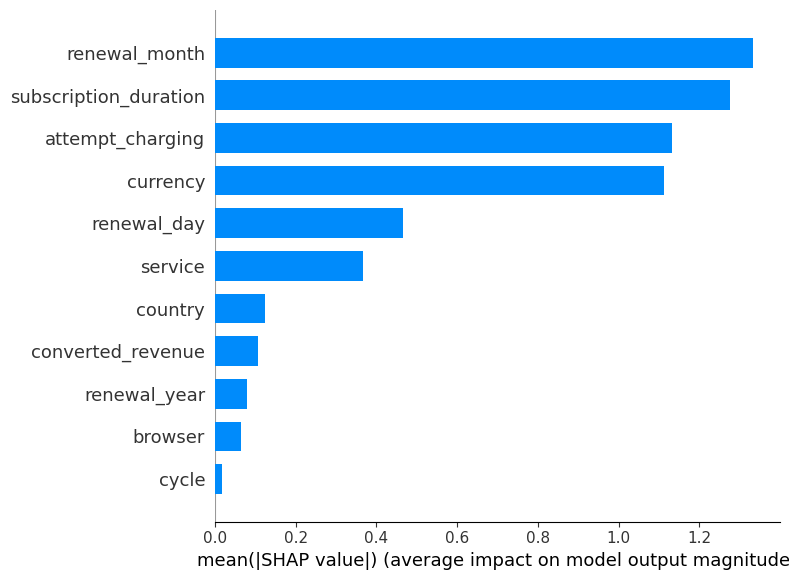

In [23]:
shap.summary_plot(shap_values, X_test, feature_names=features, class_names=target, plot_type="bar")